# 8 循环神经网络

到目前为止，我们遇到过两种类型的数据：表格数据和图像数据。对于图像数据，我们设计了专门的卷积神经网络架构来为这类特殊的数据结构建模。换句话说，如果我们拥有一张图像，我们需要有效地利用其像素位置，假若我们对图像中的像素位置进行重排，就会对图像中内容的推断造成极大的困难。

最重要的是，到目前为止我们默认数据都来自于某种分布，并且所有样本都是独立同分布的。然而，大多数的数据并非如此。例如，文章中的单词是按顺序写的，如果顺序被随机地重排，就很难理解文章原始的意思。同样，视频中的图像帧、对话中的音频信号以及网站上的浏览行为都是有顺序的。因此，针对此类数据而设计特定模型，可能效果会更好。

另一个问题来自这样一个事实：我们不仅仅可以接收一个序列作为输入，而是还可能期望继续猜测这个序列的后续。例如，一个任务可以是继续预测$2, 4, 6, 8, 10, \ldots$。这在时间序列分析中是相当常见的，可以用来预测股市的波动、患者的体温曲线或者赛车所需的加速度。同理，我们需要能够处理这些数据的特定模型。

简言之，如果说卷积神经网络可以有效地处理空间信息，那么本章的**循环神经网络**（recurrent neural network，RNN）则可以更好地处理**序列信息**。循环神经网络通过引入状态变量存储过去的信息和当前的输入，从而可以确定当前的输出。

许多使用循环网络的例子都是基于文本数据的，因此我们将在本章中重点介绍语言模型。在对序列数据进行更详细的回顾之后，我们将介绍文本预处理的实用技术。然后，我们将讨论语言模型的基本概念，并将此讨论作为循环神经网络设计的灵感。

# 8.1 序列模型

序列数据是有**前后顺序**的数据，时间序列数据是从时间维度定义顺序的序列数据。
比如，股票的价格，患者的体温都是序列数据。
在本质上，音乐、语音、文本和视频都是序列数据，如果它们的序列被我们重排，那么就会失去原有的意义。
人类之间的互动也是序列数据，这可以从微博上的争吵和辩论中看出。
处理序列数据需要统计工具和新的深度神经网络架构。

为了简单起见，我们以股票价格为例。
其中，用$x_t$表示价格，即在时间步（time step）$t \in \mathbb{Z}^+$时，观察到的价格$x_t$。
请注意，$t$对于本文中的序列通常是离散的，并在整数或其子集上变化。
假设一个交易员想在$t$日的股市中表现良好，于是通过以下途径预测$x_t$：

$$x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1).$$

为了实现这个预测，交易员可以使用**自回归模型**，用$x_{t-1}, \ldots, x_1$来预测$x_t$。有一个**主要问题**：输入数据的数量，输入$x_{t-1}, \ldots, x_1$本身因$t$而异。也就是说，输入数据的数量这个数字将会随着我们遇到的数据量的增加而增加，因此需要一个近似方法来使这个计算变得容易处理。
后面的大部分内容将围绕着如何有效估计$P(x_t \mid x_{t-1}, \ldots, x_1)$展开。
简单地说，有以下**两种策略**：

第一种策略，假设当前数据$x_t$只跟过去$\tau$个数据有关（**马尔可夫假设**），$x_{t-\tau-1}, \ldots, x_1$可能是不必要的，
因此我们只需要满足某个长度为$\tau$的时间跨度，即：使用观测序列$x_{t-1}, \ldots, x_{t-\tau}$预测$x_t$（其中$t > \tau$）。这样做最直接的好处就是参数的数量总是不变的，这种模型被称为**马尔可夫模型**。

第二种策略，如图所示：是保留一些对过去观测的总结$h_t$，并且同时更新预测$\hat{x}_t$和总结$h_t$。
这就产生了基于$\hat{x}_t = P(x_t \mid h_{t})$估计$x_t$，
以及公式$h_t = g(h_{t-1}, x_{t-1})$更新的模型。
由于$h_t$从未被观测到，这类模型也被称为
**隐变量自回归模型**（latent autoregressive models）。
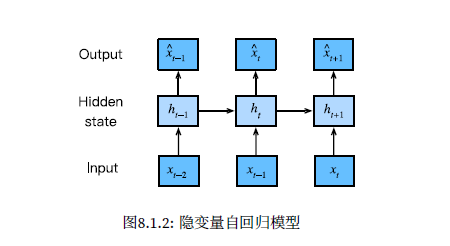

# 8.2文本预处理

文本是最常见的序列数据。
例如，一篇文章可以被简单地看作是一串单词序列，甚至是一串字符序列。
本节中，我们将解析文本的常见预处理步骤。
这些步骤通常包括：

1. 将文本作为字符串加载到内存中。
1. 将字符串拆分为**词元**（如单词和字符）。
1. 建立一个**词表**，将拆分的词元映射到数字索引。
1. 将文本转换为**数字索引**序列，方便模型操作。


In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
import collections
import re

## 8.2.1读取数据集

首先，我们从H.G.Well的[时光机器](https://www.gutenberg.org/ebooks/35)中加载文本。
这是一个相当小的语料库，只有30000多个单词，但足够我们小试牛刀，
而现实中的文档集合可能会包含数十亿个单词。
下面的函数(**将数据集读取到由多条文本行组成的列表中**)，其中每条文本行都是一个字符串。
为简单起见，我们在这里忽略了标点符号和字母大写。

In [2]:
#@save
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  #@save
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]
    #把不是字母的东西变成空格，字母全部小写

lines = read_time_machine()
print(f'# 文本总行数: {len(lines)}')
print(lines[0])
print(lines[10])

# 文本总行数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


## 8.2.2词元化

下面的`tokenize`函数将文本行列表（`lines`）作为输入，
列表中的每个元素是一个文本序列（如一条文本行）。
[**每个文本序列又被拆分成一个词元列表**]，*词元*（token）是文本的基本单位，每一个单词都是一个词元。
最后，返回一个由词元列表组成的列表，其中的每个词元都是一个字符串（string）。


In [3]:
def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


## 8.2.3词表

词元的类型是字符串，而模型需要的输入是数字，因此这种类型不方便模型使用。
现在，让我们[**构建一个字典，通常也叫做*词表*（vocabulary），
用来将字符串类型的词元映射到从$0$开始的数字索引中**]。
我们先将训练集中的所有文档合并在一起，对它们的唯一词元进行统计，
得到的统计结果称之为*语料*（corpus）。
然后根据每个唯一词元的出现频率，为其分配一个数字索引。
很少出现的词元通常被移除，这可以降低复杂性。
另外，语料库中不存在或已删除的任何词元都将映射到一个特定的未知词元“&lt;unk&gt;”。

In [4]:
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

我们首先使用时光机器数据集作为语料库来[构建词表]，然后打印前几个高频词元及其索引。

In [5]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


# 8.3语言模型和数据集

假设长度为$T$的文本序列中的词元依次为$x_1, x_2, \ldots, x_T$。
于是，$x_t$（$1 \leq t \leq T$）
可以被认为是文本序列在时间步$t$处的观测或标签。
在给定这样的文本序列时，**语言模型**（language model）的目标是估计序列的联合概率

$$P(x_1, x_2, \ldots, x_T).$$

## 8.3.1学习语言模型

我们面对的问题是如何对一个文档，甚至是一个词元序列进行建模。假设在单词级别对文本数据进行词元化，我们可以依靠对序列模型的分析。从基本概率规则开始：

$$P(x_1, x_2, \ldots, x_T) = \prod_{t=1}^T P(x_t  \mid  x_1, \ldots, x_{t-1}).$$

例如，包含了四个单词的一个文本序列的概率是：

$$P(\text{deep}, \text{learning}, \text{is}, \text{fun}) =  P(\text{deep}) P(\text{learning}  \mid  \text{deep}) P(\text{is}  \mid  \text{deep}, \text{learning}) P(\text{fun}  \mid  \text{deep}, \text{learning}, \text{is}).$$

为了训练语言模型，我们需要计算单词的概率，以及给定前面几个单词后出现某个单词的条件概率。这些概率本质上就是语言模型的参数。

训练数据集中词的概率可以根据给定词的相对词频来计算。
接下来，我们可以尝试估计:

$$\hat{P}(\text{learning} \mid \text{deep}) = \frac{n(\text{deep, learning})}{n(\text{deep})},$$

其中$n(x)$和$n(x, x')$分别是单个单词和连续单词对的出现次数。
不幸的是，由于连续单词对“deep learning”的出现频率要低得多，所以估计这类单词序列正确的概率要困难得多。
**如果数据集很小，或者单词非常罕见，又或者单词组合非常罕见，那么这类单词序列出现一次的机会可能都找不到。**


## 8.3.2马尔可夫模型与$n$元语法

将马尔可夫模型应用于语言建模。
如果$P(x_{t+1} \mid x_t, \ldots, x_1) = P(x_{t+1} \mid x_t)$，
则序列上的分布满足一阶马尔可夫性质。
阶数越高，对应的依赖关系就越长。
这种性质推导出了许多可以应用于序列建模的近似公式：

$$
\begin{aligned}
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2) P(x_3) P(x_4),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_2) P(x_4  \mid  x_3),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_1, x_2) P(x_4  \mid  x_2, x_3).
\end{aligned}
$$

通常，涉及一个、两个和三个变量的概率公式分别被称为
“一元语法”（unigram）、“二元语法”（bigram）和“三元语法”（trigram）模型。
下面，我们将学习如何去设计更好的模型。

## 8.3.3自然语言统计

我们看看在真实数据上如果进行自然语言统计。根据上一节中介绍的时光机器数据集构建词表，并打印前$10$个最常用的（频率最高的）单词。

In [7]:
import random
import torch
from d2l import torch as d2l

In [8]:
tokens = d2l.tokenize(d2l.read_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

正如我们所看到的，(**最流行的词**)看起来很无聊，
这些词通常(**被称为*停用词***)（stop words）。
尽管如此，它们本身仍然是有意义的，我们仍然会在模型中使用它们。
此外，还有个明显的问题是词频**衰减的速度相当地快**。
例如，最常用单词的词频对比，第$10$个还不到第$1$个的$1/5$。
为了更好地理解，我们可以[**画出的词频图**]：

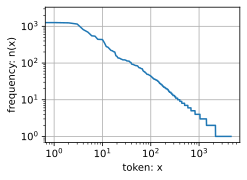

In [9]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

考虑其他词元组合，如二元语法，三元语法

In [10]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

这里值得注意：在十个最频繁的词对中，有九个是由两个停用词组成的，
只有一个与“the time”有关。
我们再进一步看看三元语法的频率是否表现出相同的行为方式。


In [11]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

最后，我们[**直观地对比三种模型中的词元频率**]：一元语法、二元语法和三元语法。

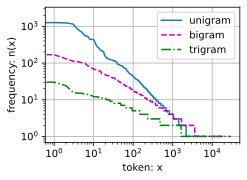

In [12]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

可以看到：
首先，除了一元语法词，二元和三元词频衰减的速度也较快，
其次，词表中$n$元组的数量并没有那么大，这说明语言中存在相当多的结构。
最后，很多$n$元组很少出现，通过词频计算概率很难预测准确。

## 8.3.4读取长序列数据

由于序列数据本质上是连续的，因此我们在处理数据时需要解决这个问题。
当**序列太长**而不能被模型一次性全部处理时，我们可能希望**拆分**这样的序列方便模型读取。

在介绍该模型之前，我们看一下总体策略。假设我们将使用神经网络来训练语言模型，
模型中的网络一次处理具有预定义长度（例如$n$个时间步）的一个小批量序列。现在的问题是如何**随机生成一个小批量数据的特征和标签以供模型读取。**

### 随机采样

(**在随机采样中，每个样本都是在原始的长序列上任意捕获的子序列。**)
在迭代过程中，来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻。
对于语言建模，目标是基于到目前为止我们看到的词元来预测下一个词元，
因此标签是移位了一个词元的原始序列。

下面的代码每次可以从数据中随机生成一个小批量。
在这里，参数`batch_size`指定了每个小批量中子序列样本的数目，
参数`num_steps`是每个子序列中预定义的时间步数。


In [13]:
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

下面我们[**生成一个从$0$到$34$的序列**]。
假设批量大小为$2$，时间步数为$5$，这意味着可以生成
$\lfloor (35 - 1) / 5 \rfloor= 6$个“特征－标签”子序列对。
如果设置小批量大小为$2$，我们只能得到$3$个小批量。


In [14]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[23, 24, 25, 26, 27],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[24, 25, 26, 27, 28],
        [19, 20, 21, 22, 23]])
X:  tensor([[13, 14, 15, 16, 17],
        [ 8,  9, 10, 11, 12]]) 
Y: tensor([[14, 15, 16, 17, 18],
        [ 9, 10, 11, 12, 13]])
X:  tensor([[ 3,  4,  5,  6,  7],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[ 4,  5,  6,  7,  8],
        [29, 30, 31, 32, 33]])


### 顺序分区

在迭代过程中，除了对原始序列可以随机抽样外，
我们还可以[**保证两个相邻的小批量中的子序列在原始序列上也是相邻的**]。
这种策略在基于小批量的迭代过程中保留了拆分的子序列的顺序，因此称为顺序分区。

In [15]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

基于相同的设置，通过顺序分区[**读取每个小批量的子序列的特征`X`和标签`Y`**]。
通过将它们打印出来可以发现：
迭代期间来自两个相邻的小批量中的子序列在原始序列中确实是相邻的。

In [16]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 0,  1,  2,  3,  4],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 1,  2,  3,  4,  5],
        [18, 19, 20, 21, 22]])
X:  tensor([[ 5,  6,  7,  8,  9],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[ 6,  7,  8,  9, 10],
        [23, 24, 25, 26, 27]])
X:  tensor([[10, 11, 12, 13, 14],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [28, 29, 30, 31, 32]])


现在，我们[将上面的两个采样函数包装到一个类中]， 以便稍后可以将其用作数据迭代器。

In [17]:
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

[**最后，我们定义了一个函数`load_data_time_machine`，
它同时返回数据迭代器和词表**]，

In [18]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

# 8.4循环神经网络

我们介绍了$n$元语法模型，
其中单词$x_t$在时间步$t$的条件概率仅取决于前面$n-1$个单词。
对于时间步$t-(n-1)$之前的单词，
如果我们想将其可能产生的影响合并到$x_t$上，
需要增加$n$，然而模型参数的数量也会随之呈指数增长，
因此与其将$P(x_t \mid x_{t-1}, \ldots, x_{t-n+1})$模型化，
不如使用隐变量模型：

$$P(x_t \mid x_{t-1}, \ldots, x_1) \approx P(x_t \mid h_{t-1}),$$

其中$h_{t-1}$是*隐状态*（hidden state），
也称为*隐藏变量*（hidden variable），
它存储了到时间步$t-1$的序列信息。
通常，我们可以基于当前输入$x_{t}$和先前隐状态$h_{t-1}$
来计算时间步$t$处的任何时间的隐状态：

$$h_t = f(x_{t}, h_{t-1}).$$

对于足够强大的函数$f$，隐变量模型不是近似值。
毕竟$h_t$是可以仅仅存储到目前为止观察到的所有数据，
然而这样的操作可能会使计算和存储的代价都变得昂贵。

值得注意的是，隐藏层和隐状态指的是两个截然不同的概念。**循环神经网络**（recurrent neural networks，RNNs）
是具有隐状态的神经网络。

## 8.4.1无隐状态的多层感知机

让我们来看一看只有单隐藏层的多层感知机。
设隐藏层的激活函数为$\phi$，
给定一个小批量样本$\mathbf{X} \in \mathbb{R}^{n \times d}$，
其中批量大小为$n$，输入维度为$d$，
则隐藏层的输出$\mathbf{H} \in \mathbb{R}^{n \times h}$通过下式计算：

$$\mathbf{H} = \phi(\mathbf{X} \mathbf{W}_{xh} + \mathbf{b}_h).$$

隐藏层权重参数为$\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$，
偏置参数为$\mathbf{b}_h \in \mathbb{R}^{1 \times h}$，
以及隐藏单元的数目为$h$。
接下来，将隐藏变量$\mathbf{H}$用作输出层的输入。
输出层由下式给出：

$$\mathbf{O} = \mathbf{H} \mathbf{W}_{hq} + \mathbf{b}_q,$$

其中，$\mathbf{O} \in \mathbb{R}^{n \times q}$是输出变量，
$\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$是权重参数，
$\mathbf{b}_q \in \mathbb{R}^{1 \times q}$是输出层的偏置参数。

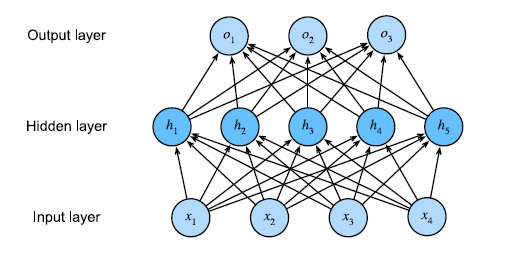

## 8.4.2有隐状态的循环神经网络

有了隐状态后，情况就完全不同了。
假设我们在时间步$t$有小批量输入$\mathbf{X}_t \in \mathbb{R}^{n \times d}$。
换言之，对于$n$个序列样本的小批量，
$\mathbf{X}_t$的每一行对应于来自该序列的时间步$t$处的一个样本。
接下来，用$\mathbf{H}_t  \in \mathbb{R}^{n \times h}$
表示时间步$t$的隐藏变量。
与多层感知机不同的是，
我们在这里保存了前一个时间步的隐藏变量$\mathbf{H}_{t-1}$，
并引入了一个新的权重参数$\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$，
来描述如何在当前时间步中使用前一个时间步的隐藏变量。
具体地说，当前时间步隐藏变量由当前时间步的输入
与前一个时间步的隐藏变量一起计算得出：

$$\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}  + \mathbf{b}_h).$$

与 多层感知机隐藏层相比，多添加了一项$\mathbf{H}_{t-1} \mathbf{W}_{hh}$。
从相邻时间步的隐藏变量$\mathbf{H}_t$和
$\mathbf{H}_{t-1}$之间的关系可知，
这些变量捕获并保留了序列直到其当前时间步的历史信息，就如当前时间步下神经网络的状态或记忆，因此这样的隐藏变量被称为**隐状态**（hidden state）。
由于在当前时间步中，
隐状态使用的定义与前一个时间步中使用的定义相同，
因此 上式的计算是*循环的*（recurrent）。
于是基于循环计算的隐状态神经网络被命名为
*循环神经网络*（recurrent neural network）。
在循环神经网络中执行上式的层称为*循环层*（recurrent layer）。

对于时间步$t$，输出层的输出类似于多层感知机中的计算：

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q.$$

循环神经网络的参数包括隐藏层的权重
$\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$和偏置$\mathbf{b}_h \in \mathbb{R}^{1 \times h}$，
以及输出层的权重$\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$
和偏置$\mathbf{b}_q \in \mathbb{R}^{1 \times q}$。

下图展示了循环神经网络在三个相邻时间步的计算逻辑。
在任意时间步$t$，隐状态的计算可以被视为：

1. 拼接当前时间步$t$的输入$\mathbf{X}_t$和前一时间步$t-1$的隐状态$\mathbf{H}_{t-1}$；
1. 将拼接的结果送入带有激活函数$\phi$的全连接层。
   全连接层的输出是当前时间步$t$的隐状态$\mathbf{H}_t$。

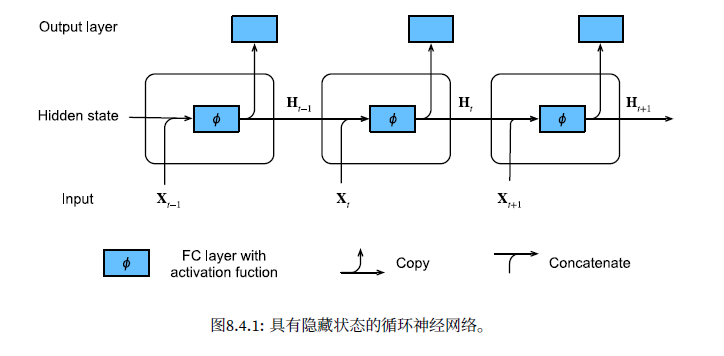

当前时间步$t$的隐状态$\mathbf{H}_t$
将参与计算下一时间步$t+1$的隐状态$\mathbf{H}_{t+1}$。
而且$\mathbf{H}_t$还将送入全连接输出层，
用于计算当前时间步$t$的输出$\mathbf{O}_t$。

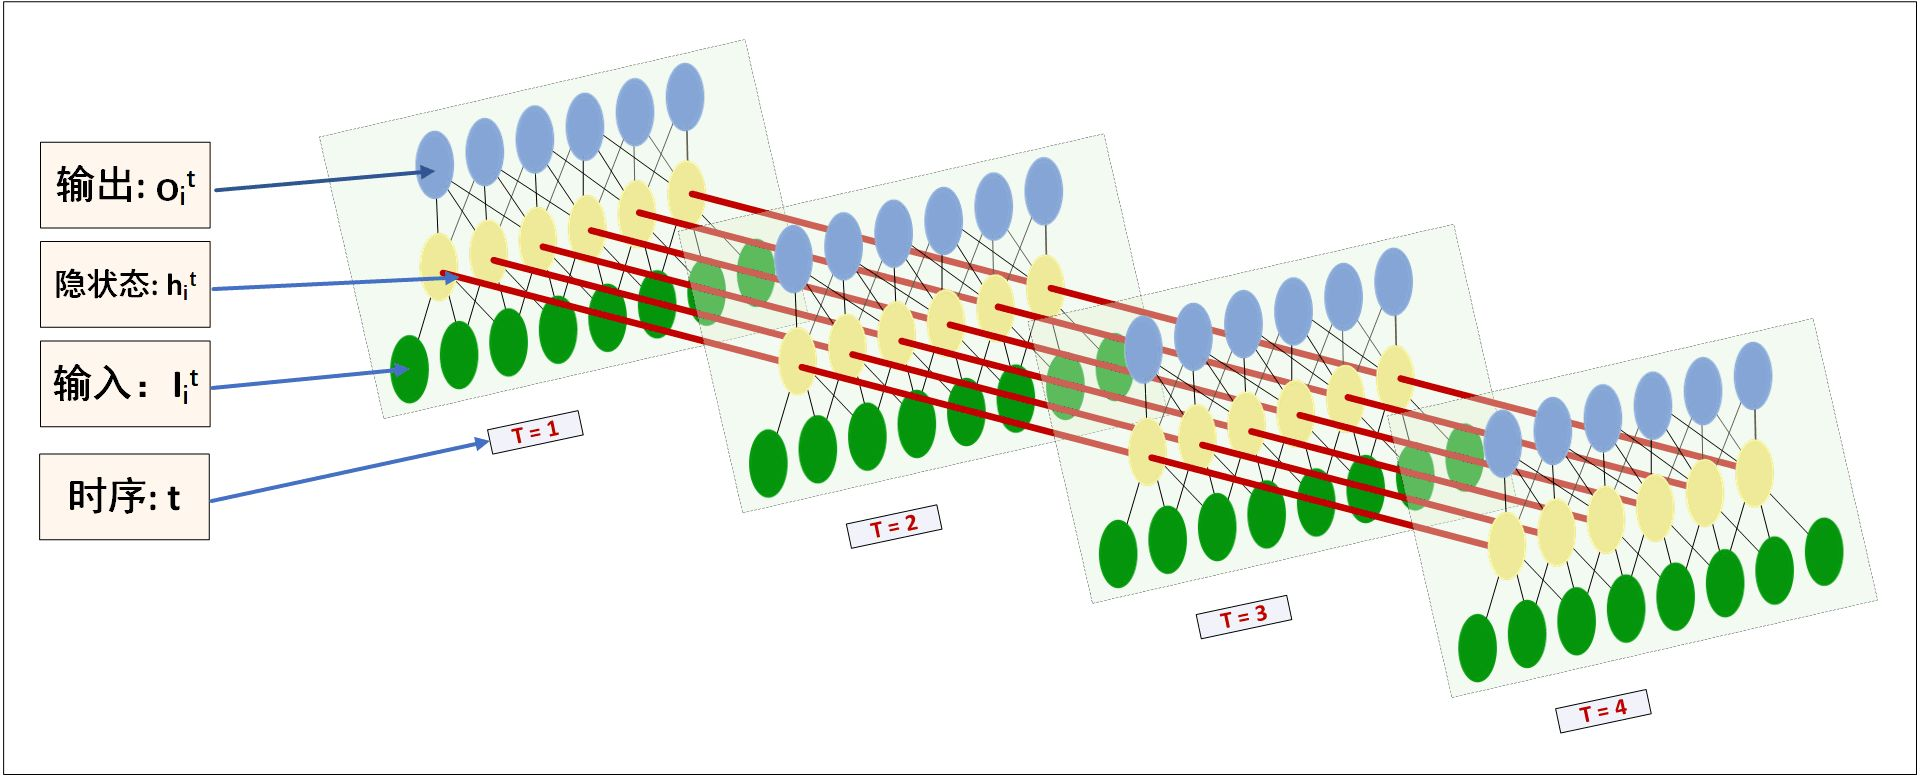

## 8.4.3基于循环神经网络的字符级语言模型

之前的语言模型，我们的目标是根据过去的和当前的词元预测下一个词元，因此我们将原始序列移位一个词元作为标签。
接下来，我们看一下如何使用循环神经网络来构建语言模型。
设小批量大小为1，批量中的那个文本序列为“machine”。为了简化后续部分的训练，我们考虑使用
**字符级语言模型**（character-level language model），**将文本词元化为字符而不是单词**。
下图演示了如何通过基于字符级语言建模的循环神经网络，使用当前的和先前的字符预测下一个字符。

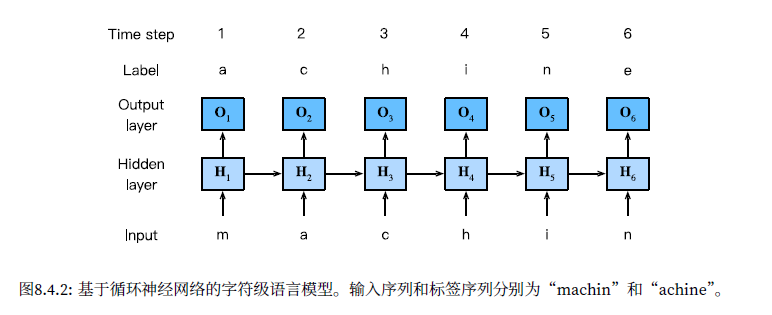

图中的第$3$个时间步的输出$\mathbf{O}_3$
由文本序列“m”、“a”和“c”确定。
由于训练数据中这个文本序列的下一个字符是“h”，
因此第$3$个时间步的损失将取决于下一个字符的概率分布，
而下一个字符是基于特征序列“m”、“a”、“c”和这个时间步的标签“h”生成的。

在实践中，我们使用的批量大小为$n>1$，
每个词元都由一个$d$维向量表示。
因此，在时间步$t$输入$\mathbf X_t$将是一个$n\times d$矩阵，
这与我们在 :numref:`subsec_rnn_w_hidden_states`中的讨论相同。

## 8.4.4困惑度（Perplexity）

最后，让我们讨论如何度量语言模型的质量，
这将在后续部分中用于评估基于循环神经网络的模型。
一个好的语言模型能够用高度准确的词元来预测我们接下来会看到什么。
考虑一下由不同的语言模型给出的对“It is raining ...”（“...下雨了”）的续写：

1. "It is raining outside"（外面下雨了）
1. "It is raining banana tree"（香蕉树下雨了）
1. "It is raining piouw;kcj pwepoiut"（piouw;kcj pwepoiut下雨了）

就质量而言，例$1$显然是最合乎情理、在逻辑上最连贯的。
虽然这个模型可能没有很准确地反映出后续词的语义，
比如，后续是“It is raining in San Francisco”（旧金山下雨了）
但该模型已经能够捕捉到跟在后面的是哪类单词。
例$2$则要糟糕得多，因为其产生了一个无意义的续写。尽管如此，至少该模型已经学会了如何拼写单词，以及单词之间的某种程度的相关性。
最后，例$3$表明了训练不足的模型是无法正确地拟合数据的。

我们可以通过一个序列中所有的$n$个词元的交叉熵损失的平均值来衡量模型的质量：

$$\frac{1}{n} \sum_{t=1}^n -\log P(x_t \mid x_{t-1}, \ldots, x_1),$$

其中$P$由语言模型给出，
$x_t$是在时间步$t$从该序列中观察到的实际词元。
这使得不同长度的文档的性能具有了可比性。
由于历史原因，自然语言处理的科学家更喜欢使用一个叫做*困惑度*（perplexity）的量。
简而言之，它是上式的指数：

$$\exp\left(-\frac{1}{n} \sum_{t=1}^n \log P(x_t \mid x_{t-1}, \ldots, x_1)\right).$$

困惑度的最好的理解是“下一个词元的实际选择数的调和平均数”。
我们看看一些案例：

* 在最好的情况下，模型总是完美地估计标签词元的概率为1。
  在这种情况下，模型的困惑度为1。
* 在最坏的情况下，模型总是预测标签词元的概率为0。
  在这种情况下，困惑度是正无穷大。
* 在基线上，该模型的预测是词表的所有可用词元上的均匀分布。
  在这种情况下，困惑度等于词表中唯一词元的数量。
  事实上，如果我们在没有任何压缩的情况下存储序列，
  这将是我们能做的最好的编码方式。
  因此，这种方式提供了一个重要的上限，
  而任何实际模型都必须超越这个上限。

接下来，我们将基于循环神经网络实现字符级语言模型，并使用困惑度来评估这样的模型。

# 8.5循环神经网络的实现

本节将展示如何使用深度学习框架的高级API提供的函数更有效地实现相同的语言模型。
我们仍然从读取时光机器数据集开始。


In [19]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## [**定义模型**]

高级API提供了循环神经网络的实现。
我们构造一个具有256个隐藏单元的单隐藏层的循环神经网络层`rnn_layer`。

In [20]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

我们(**使用张量来初始化隐状态**)，它的形状是（隐藏层数，批量大小，隐藏单元数）。

In [21]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

[**通过一个隐状态和一个输入，我们就可以用更新后的隐状态计算输出。**]
需要强调的是，`rnn_layer`的“输出”（`Y`）不是输出层的计算：
它是指每个时间步的隐状态，这些隐状态可以用作后续输出层的输入。

In [22]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [23]:
X.shape

torch.Size([35, 32, 28])

[**我们为一个完整的循环神经网络模型定义了一个`RNNModel`类**]。
注意，`rnn_layer`只包含隐藏的循环层，我们还需要创建一个单独的输出层。

In [24]:
#@save
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

## 训练与预测

In [25]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)

困惑度 1.3, 14933.1 词元/秒 cpu
time traveller held in his hand was a glatith a ofile wither abr
travelleryou car smowithal say hat il the oureat a doxint a


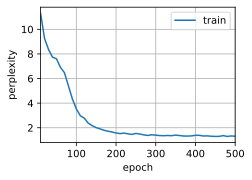

In [26]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)